# Laboratorio de Introducción al Procesamiento de Lenguaje Natural 2017

#### Número de grupo: 13
#### Integrantes:
- Giovani Rondán, CI: 4.528.997-6
- Santiago Behak, CI: 5.019.450-0

## 1- Importación de los tweets.

Comenzaremos importando los tweets provenientes del archivo "corpus_humor_training.csv" usando la librería Pandas:

In [69]:
import pandas
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
import re
#import freeling
from pylab import *
import numpy as np
from nltk.corpus import stopwords
import IPython.display as disp
import os

corpus = pandas.read_csv("corpus_humor_training.csv",encoding='utf-8')

Los registros de este corpus están compuestos por varios datos además del propio texto del tweet. A continuación mostraremos la estructura del corpus y algunos de los tweets (que se encuentran en el atributo "text") a modo de ejemplo:

In [70]:
print(corpus.columns)
print ("\n")
for text in corpus['text'][:7]:
    print(text + '\n')

Index(['id', 'text', 'account_id', 'n', '1', '2', '3', '4', '5'], dtype='object')


-La semana pasada mi hijo hizo un triple salto mortal desde 20 metros de altura - ¿Es trapecista? -Era :(

-Yo ya voy por mi segundo millón de dólares... -¿!Ah, si!? -Es que el primero nunca lo hice... #fb

-Ayer fue mi cumpleaños y no me felicitaste - ¡FéÉLíCÍDáÁDÉéS! - ¿Qué haces? -Felicitarte con retraso.

No es flojera, es un estado de ahorro de energía corporal :)

- ¿Cómo te fue en matemática? -Vos sabes que soy muy pacífica - ¿Y eso qué tiene que ver? -No me gustan los problemas jajaja -Castigada - :(

"El pesimista se queja del viento; el optimista espera que cambie; el realista ajusta las velas" Feliz miércoles.

-¿Y tú desde cuando llevas pendiente? 
-Desde que mi mujer se lo encontró en el coche y le dije que era mío...



A continuación porocedemos a analizar las características del corpus obtenido, para esto obtendremos algunos datos básicos tales como la cantidad total de tweets, la cantidad de atributos de los que disponemos, la cantidad de calificaciones de los 10 tweets más calificados y la cantidad total de calificaciones.

In [71]:
cantTweets = len(corpus)
cantAtributos = len(corpus.columns)

# Imprimimos la cantidad total de tweets y la cantidad de atributos
print ("Cantidad de Tweets en el corpus: " + str(cantTweets))
print ("Cantidad de atributos en el corpus: " + str(cantAtributos))

# Imprimimos la cantidad de calificaciones de los 10 tweets mas calificados y la cantidad total de calificaciones
totalCalificaciones = 0
contador = 0
corpus["cantCalificaciones"] = [0]*len(corpus)
for i in range(0, 12106):
    calificacionesTweet =corpus.loc[i, "n"] + corpus.loc[i, "1"]  + corpus.loc[i, "2"] + corpus.loc[i, "3"] + corpus.loc[i, "4"] + corpus.loc[i, "5"]
    totalCalificaciones += calificacionesTweet
    corpus.loc[i, "cantCalificaciones"] = calificacionesTweet

print ("Lista de los diez tweets con más calificaciones:\n")
disp.display(corpus.sort_values(by = ['cantCalificaciones'], ascending = False).head(10))

Cantidad de Tweets en el corpus: 12106
Cantidad de atributos en el corpus: 9
Lista de los diez tweets con más calificaciones:



,id,text,account_id,n,1,2,3,4,5,cantCalificaciones
5879,445969156437852161,"—¿A dónde vas tan maquillada? —A una fiesta, m...",1518218509,2,6,3,2,6,2,21
8158,446273545304162304,"JAJAJAJAJAJA ¿TE ACUERDAS CUANDO... ah, no, tú...",229144847,13,2,1,4,0,0,20
10238,446423336831053824,"""Tu invades mi cabeza"" —Juanita, 10 años, tien...",229144847,4,6,4,3,2,0,19
11728,464188098780618752,#Chistetipico,124053720,17,0,0,0,1,0,18
7849,447042317480763393,"""Es imposible"" dijo el orgullo; ""es arriesgado...",1518218509,6,6,1,1,3,0,17
8966,448704341365366784,-Tenemos una relación seria. -¿Lleváis mucho t...,1518218509,1,2,4,3,3,4,17
1117,446934186889211905,"Hablo 3 idiomas: español, sarcasmos e indirectas.",1518218509,6,4,1,4,0,1,16
7037,445481775133777921,Molestar a alguien solo porque te gusta ver co...,1518218509,14,1,0,1,0,0,16
9273,445669834211069952,A mi también me castigaron por reírme mientras...,1518218509,11,3,0,0,2,0,16
4306,447613590992732160,"—En mis tiempos... —Sí, sí abuela, como digas,...",1518218509,4,1,3,4,2,1,15


Otro dato que puede resultar interesante es la cantidad de calificaciones por valor (las calificaciones no humorísiticas serán contadas con el 0).

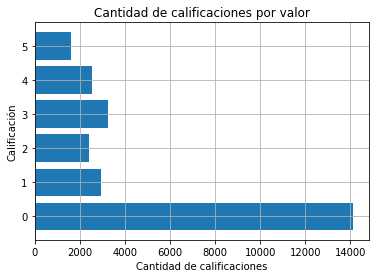

In [72]:
%matplotlib inline

# Se realiza una gráfica de cantidad de comentarios en función de su clasificación
calificacionesPorValor = [corpus["n"].sum(), corpus["1"].sum(), corpus["2"].sum(), corpus["3"].sum(), corpus["4"].sum(), corpus["5"].sum()]
valoresCalificaciones = ["0", "1", "2", "3", "4", "5"]
pos = arange(len(valoresCalificaciones)) + 0.5 

figure(1)
barh(pos,calificacionesPorValor, align='center')
yticks(pos, valoresCalificaciones)
xlabel('Cantidad de calificaciones')
ylabel(u'Calificación')
title(u'Cantidad de calificaciones por valor')
grid(True)
show()

Como se puede ver en la gráfica la mayoría de las calificaciones corresponden al valor 0, o sea, como calificaciones no humorísticas.

## 2- Preprocesmiento de los datos

En primer lugar procederemos a eleminar las columnas del corpus que consideramos innecesarias. Eliminaremos la columna de la id del tweet ya que este es un número autogenerado aleatorio que no debería aportar información relevante.

In [73]:
if "id" in corpus.columns:
    del corpus["id"]
print (corpus.columns)


Index(['text', 'account_id', 'n', '1', '2', '3', '4', '5',
       'cantCalificaciones'],
      dtype='object')


Una vez filtradas las columnas del corpus nos disponemos a filtrar los tweets que tienen menos de tres calificaciones dado que los mismos no cuentan con una cantidad significativa de calificaciones como para ser evaluados. Además se eliminarán los hashtags de los textos de los tweets como se pide en la letra y agregaremos una nueva columna que determina si un tweet es humorístico en función del número de calificaciones no humorísticas en relación al total de calificaciones del tweet. Si la cantidad de calificaciones humorísticas es mayor o igual a la suma del resto de calificaciones el tweet se considerará no humorístico.

In [81]:
corpus["humoristico"] = [False]*len(corpus)
corpus_filtrado = pandas.DataFrame(columns = ['text', 'account_id', 'n', '1', '2', '3', '4', '5', 'humoristico', 'cantCalificaciones'])
#corpus_filtrado = corpus[corpus.n + corpus.columns[4] + corpus.columns[5] + corpus.columns[6] + corpus.columns[7] + corpus.columns[8] >= 3]
total = 0
for i in range(0, 12106):
    contador = corpus.loc[i, "cantCalificaciones"]
    #eliminamos los hashtags
    corpus.loc[i, "text"] = re.sub(r"#\S+\s*", "", corpus.loc[i, "text"])
    #definimos si un tweet es humoristico o no segun los votos
    if(contador/2 >= corpus.loc[i, "n"]):
        corpus.loc[i, "humoristico"] = True
    #filtramos los tweets que tienen menos de 3 votos
    if contador >= 3:
        corpus_filtrado.loc[total] = [corpus.loc[i, "text"], corpus.loc[i, "account_id"], corpus.loc[i, "n"], corpus.loc[i, "1"], corpus.loc[i, "2"], corpus.loc[i, "3"], corpus.loc[i, "4"], corpus.loc[i, "5"], corpus.loc[i, "humoristico"], corpus.loc[i, "cantCalificaciones"]]
        total += 1
        
#columna 3 -> n, 4 -> 1, 5 -> 2, 6 -> 3, 7 -> 4, 8 -> 5

disp.display(corpus_filtrado.loc[0:10, :])
print ("Cantidad de tweets que quedan en el corpus luego del filtrado: " + str(len(corpus_filtrado)))

,text,account_id,n,1,2,3,4,5,humoristico,cantCalificaciones
0,-La semana pasada mi hijo hizo un triple salto...,118161896,0,1,1,0,0,1,True,3
1,-Yo ya voy por mi segundo millón de dólares......,132679073,2,1,0,0,0,0,False,3
2,-Ayer fue mi cumpleaños y no me felicitaste - ...,118161896,0,1,1,1,0,1,True,4
3,"No es flojera, es un estado de ahorro de energ...",1518218509,1,1,1,0,0,0,True,3
4,- ¿Cómo te fue en matemática? -Vos sabes que s...,118161896,2,0,0,1,0,0,False,3
5,"-Compadre, su hija antes me daba como por las ...",132679073,1,1,0,0,1,0,True,3
6,Había una vez una tortuguita que fue a su prim...,142482558,1,2,1,0,0,0,True,4
7,"Una novia que sea tan delicada como Neymar, es...",142482558,2,0,0,0,1,0,False,3
8,¿Qué le dice el Nesquik a la leche? ¡Te voy a ...,132679073,2,1,0,0,1,0,True,4
9,Si oscar se queda me pego un tiro con un banan...,574848706,6,1,1,0,1,0,False,9


Cantidad de tweets que quedan en el corpus luego del filtrado: 3438


## 3- Separación de los datos en conjunto de train y test

A continuación dividiremos el corpus restante en un conjunto de train y en otro de test. En principio usaremos un 80% de los datos para el entrenamiento y un 20% para el testeo.

In [82]:
corpus_train, corpus_test = train_test_split(corpus_filtrado, test_size=0.2)

print ("Cantidad de tweets en el conjunto de entrenamiento: " + str(len(corpus_train)))
print ("Cantidad de tweets en el conjunto de testeo: " + str(len(corpus_test)))

Cantidad de tweets en el conjunto de entrenamiento: 2750
Cantidad de tweets en el conjunto de testeo: 688


## 4- Clasificador binario con tokenizador y POS tag de Freeling

### 4-1 Tokenización del corpus usando Freeling

Una vez separados el conjunto de train y test procedemos a tokenizar los tweets provenientes del conjunto train. Para esto usaremos la librería Freeling y NLTK. Primero definiremos una función que tokeniza un corpus usando freeling y a la que se le pueden pasar filtros para eliminar palabras basados en el postag de Freeling:

In [83]:
from subprocess import Popen, PIPE, STDOUT
import datetime
import traceback as tb

def filtrar_corpus(corpus, filtros, train, lemma = False, usuario = False, with_tag = False):
    result = []
    palabras = ""
    finTweetH = "13grupoPLN"
    finTweetNH = "13grupoIPLN"
    
    for index, tweet in corpus.iterrows():
        palabras+= tweet["text"]
        palabras+= ". "
        if(tweet["humoristico"]):
            palabras+= finTweetH
        else:
            palabras+= finTweetNH
        palabras+= ". "

    p = Popen("C:/Users/Usuario/Desktop/PLN2017/FreelingWindows/bin/analyzer.bat -f C:/Users/Usuario/Desktop/PLN2017/FreelingWindows/data/config/es.cfg", shell = True, stdout=PIPE, stdin=PIPE, stderr=STDOUT)
    stdout = p.communicate(input=palabras.encode())[0]
    iterator = -1
    tweets = stdout.decode().split('\r\n')
    for index, row in corpus.iterrows():
        iterator += 1
        tokens = tweets[iterator].split(' ')
        diccionario = {}
        while (tokens[0] != finTweetH and tokens[0] != finTweetNH):
            if(tokens[0] != ''):
                if(lemma):
                    token = tokens[1]
                else:
                    token = tokens[0]
                tag = tokens[2]
                flag = True
                for filtro in filtros:
                    tag_aux = tag[0:len(filtro)]
                    if (tag_aux == filtro):
                        flag = False
                        break
                if flag:
                    if(token in diccionario):
                        diccionario[token] += 1
                    else:
                        diccionario[token] = 1
                    if(with_tag):
                        if(tag in diccionario):
                            diccionario[tag] += 1
                        else:
                            diccionario[tag] = 1
            tokens = tweets[iterator].split(' ')
            iterator += 1
        if(usuario):
            hola = row["account_id"]
            diccionario[hola] = 1
        if(train):
            result.append((diccionario, tokens[0] == finTweetH))
        else:
            result.append(diccionario)

    return result

### 4-2 Pruebas de clasificadores y filtros

Con esta función probaremos dos clasificadores (Naive Bayes y Máxima Entropía) y un conjunto de filtros para eliminar tokens que en principio no parecen tan interesantes. Los filtros que consideramos probar son: "F" (signos de puntuacion), "D" (determinantes), "P" (pronombres), "S" (aposiciones) y "Z" (números). Probaremos usar todas las combinaciones de clasificadores y filtros y veremos cuales dan mejores resultados. Por ahora los únicos features que usaremos para la clasificación serán la forma de las palabras, luego agregaremos más features una vez que obtengamos la configuración ideal. (Atención, la siguiente cell demora mucho en ejecutarse)

In [88]:
import nltk
from nltk.metrics.scores import *
import itertools

max_accuracy = 0
filtros = ["F", "D", "P", "S", "Z"]
for i in range(1, len(filtros) + 1):
    filter_combinations = itertools.combinations(filtros, i)
    for filter_combination in filter_combinations:
        corpus_pos_tagging = filtrar_corpus(corpus_train, filter_combination, True)
        classifiers = []
        classifiers += [[nltk.classify.NaiveBayesClassifier.train(corpus_pos_tagging), "Naive Bayes"]]
        classifiers += [[nltk.classify.MaxentClassifier.train(corpus_pos_tagging, max_iter=8,trace=0), "Maxima Entropia"]]

        print("entrene")
        #for classifier in classifiers:
        #    classifier[0].show_most_informative_features()
        salida = []
        corpus_test_tokenizado = filtrar_corpus(corpus_test, filter_combination, False)
        for classifier in classifiers:
            salidaClasificador = []
            for tweet in corpus_test_tokenizado:
                # Se obtiene la clasificacion del algoritmo para el comentario
                try:
                    clasificacion = classifier[0].classify(tweet)
                    salidaClasificador.append(clasificacion)
                except:
                    pass

            salida = corpus_test.loc[:, "humoristico"]
            cm = nltk.ConfusionMatrix(salidaClasificador, salida)
            print("Matriz de confusión de " + classifier[1] + " con filtros: " + '-'.join(filter_combination))
            print(cm)
            acc = accuracy(salidaClasificador, salida)
            print("Accuracy: " + str(acc))
            if acc > max_accuracy:
                max_accuracy = acc
                best_combination = filter_combination
                
print("\n Mejor combinacion: " + '-'.join(best_combination) + "\n Mejor accuracy: " + str(max_accuracy))

entrene
Matriz de confusión de Naive Bayes con filtros: F
  |   0   1   2 |
--+-------------+
0 |<198> 72   . |
1 | 141<277>  . |
2 |   .   .  <.>|
--+-------------+
(row = reference; col = test)

Accuracy: 0.690406976744186
Matriz de confusión de Maxima Entropia con filtros: F
  |   0   1   2 |
--+-------------+
0 |<223> 89   . |
1 | 116<260>  . |
2 |   .   .  <.>|
--+-------------+
(row = reference; col = test)

Accuracy: 0.7020348837209303
entrene
Matriz de confusión de Naive Bayes con filtros: D
  |   0   1   2 |
--+-------------+
0 |<203> 59   . |
1 | 136<290>  . |
2 |   .   .  <.>|
--+-------------+
(row = reference; col = test)

Accuracy: 0.7165697674418605
Matriz de confusión de Maxima Entropia con filtros: D
  |   0   1   2 |
--+-------------+
0 |<250> 77   . |
1 |  89<272>  . |
2 |   .   .  <.>|
--+-------------+
(row = reference; col = test)

Accuracy: 0.7587209302325582
entrene
Matriz de confusión de Naive Bayes con filtros: P
  |   0   1   2 |
--+-------------+
0 |<204> 59

entrene
Matriz de confusión de Naive Bayes con filtros: F-P-Z
  |   0   1   2 |
--+-------------+
0 |<202> 84   . |
1 | 137<265>  . |
2 |   .   .  <.>|
--+-------------+
(row = reference; col = test)

Accuracy: 0.6787790697674418
Matriz de confusión de Maxima Entropia con filtros: F-P-Z
  |   0   1   2 |
--+-------------+
0 |<216> 87   . |
1 | 123<262>  . |
2 |   .   .  <.>|
--+-------------+
(row = reference; col = test)

Accuracy: 0.6947674418604651
entrene
Matriz de confusión de Naive Bayes con filtros: F-S-Z
  |   0   1   2 |
--+-------------+
0 |<199> 74   . |
1 | 140<275>  . |
2 |   .   .  <.>|
--+-------------+
(row = reference; col = test)

Accuracy: 0.688953488372093
Matriz de confusión de Maxima Entropia con filtros: F-S-Z
  |   0   1   2 |
--+-------------+
0 |<224> 86   . |
1 | 115<263>  . |
2 |   .   .  <.>|
--+-------------+
(row = reference; col = test)

Accuracy: 0.7078488372093024
entrene
Matriz de confusión de Naive Bayes con filtros: D-P-S
  |   0   1   2 |
--+------

Después de varias ejecuciones con diferentes conjuntos de test comprobamos que Máxima Entropía es claramente mejor que Naive Bayes para este clasificador: en todos los casos probados Máxima Entropía obtiene entre 2 y 5 puntos más de precisión que Naive Bayes. Además se puede ver que existen variaciones significativas de precisión para los diferentes filtros (en general existe una diferencia de 8 puntos entre la mejor y la peor combinación), en particular la precisión baja de forma apreciable en las combinaciones que poseen el filtro "F" (correspondiente a los signos de puntuación). De hecho si se listan los features más significativos de Naive Bayes sin aplicar ningún filtro se puede ver que de hecho el guión "-" es el token que aporta más información:

In [91]:
corpus_pos_tagging = filtrar_corpus(corpus_train, [], True)
classifier = nltk.classify.NaiveBayesClassifier.train(corpus_pos_tagging)
classifier.show_most_informative_features()

Most Informative Features
                       - = 6                True : False  =     19.0 : 1.0
                       - = 4                True : False  =     15.5 : 1.0
                      rt = 1               False : True   =     15.3 : 1.0
                buen_dia = 1               False : True   =     14.5 : 1.0
                       - = 5                True : False  =     11.5 : 1.0
                       @ = 2               False : True   =     10.2 : 1.0
                 escuela = 1                True : False  =      9.9 : 1.0
                    ayyy = 1                True : False  =      9.9 : 1.0
                    cómo = 1                True : False  =      9.0 : 1.0
                      rt = 2               False : True   =      8.4 : 1.0


Probablemente esto se debe a que el guión se usa para simular diálogos, los cuáles son muy frecuentes en los chistes y los relatos.


### 4-3 Pruebas con nuevos features

La prueba anterior nos permite obtener entre un 70% y un 75% de precisión, así que intentaremos mejorar estos resultados agregando nuevos features como pueden ser la id del usuario, usar el lema de las palabras en lugar de su forma y el pos-tag devuelto por Freeling para los tokens. Para estas pruebas mantendremos el clasificador de Máxima Entropía además de todos los filtros menos el de los signos de puntuación porque, como ya discutimos, estos fueron los que dieron mejores resultados en las pruebas anteriores.

In [93]:
import nltk
from nltk.metrics.scores import *

best_accuracy = 0

for i in range(0, 8):
    aux_i = i
    bool1 = (1 == (aux_i % 2))
    aux_i = aux_i // 2
    bool2 = (1 == (aux_i % 2))
    aux_i = aux_i // 2
    bool3 = (1 == (aux_i % 2))
    corpus_pos_tagging = filtrar_corpus(corpus_train, ["P", "S", "Z", "D"], True, bool1, bool2, bool3)
    clf = nltk.classify.MaxentClassifier.train(corpus_pos_tagging, max_iter=8,trace=0)
    corpus_test_tokenizado = filtrar_corpus(corpus_test, ["P", "S", "Z", "D"], False, bool1, bool2, bool3)
    clasificacionCLF = []
    clasificacionOficial = []
    for tweet in corpus_test_tokenizado:
        #Clasificamos los tweets del corpus de test
        clasificacion = clf.classify(tweet)
        clasificacionCLF.append(clasificacion)

    #Obtenemos las clasificaciones oficiales de los tweets del conjunto de test para compararlos con los del clasificador
    clasificacionOficial = corpus_test.loc[:, "humoristico"]
    cm = nltk.ConfusionMatrix(clasificacionCLF, clasificacionOficial)
    print("Matriz de confusión con features: " + str(bool1) + "-" + str(bool2) + "-" + str(bool3))
    print(cm)
    acc = accuracy(clasificacionCLF, clasificacionOficial)
    print("Accuracy: " + str(acc))
    
    if(acc > best_accuracy):
        best_accuracy = acc
        best_features = [bool1, bool2, bool3]

print("Mejor combinacion de features: " + str(best_features[0]) + "-" + str(best_features[1]) + "-" + str(best_features[2]))


Matriz de confusión con features: False-False-False
  |   0   1   2 |
--+-------------+
0 |<236> 85   . |
1 | 103<264>  . |
2 |   .   .  <.>|
--+-------------+
(row = reference; col = test)

Accuracy: 0.7267441860465116
Matriz de confusión con features: True-False-False
  |   0   1   2 |
--+-------------+
0 |<244> 80   . |
1 |  95<269>  . |
2 |   .   .  <.>|
--+-------------+
(row = reference; col = test)

Accuracy: 0.7456395348837209
Matriz de confusión con features: False-True-False
  |   0   1   2 |
--+-------------+
0 |<247> 83   . |
1 |  92<266>  . |
2 |   .   .  <.>|
--+-------------+
(row = reference; col = test)

Accuracy: 0.7456395348837209
Matriz de confusión con features: True-True-False
  |   0   1   2 |
--+-------------+
0 |<249> 75   . |
1 |  90<274>  . |
2 |   .   .  <.>|
--+-------------+
(row = reference; col = test)

Accuracy: 0.7601744186046512
Matriz de confusión con features: False-False-True
  |   0   1   2 |
--+-------------+
0 |<251> 86   . |
1 |  88<263>  . |
2

Los resultados indican que los mejores resultados se obtienen cuando todas las features mencionadas (usuario, lema de la palabra, y pos-tags de Freeling) están presentes. En general se obtiene una mejora de 4 o 5 puntos con respecto a la prueba anterior y de esta forma alcanzamos entre 74% y 79% de precisión.

### 4.1- Tokenización

In [22]:
salida = corpus_test.loc[:, "humoristico"]
print(salida)
disp.display(corpus_test)

3346     True
2563    False
2648     True
449      True
1251     True
1548    False
2513    False
994      True
3179     True
1262     True
262     False
1470    False
1604    False
2197    False
1207    False
35       True
1396    False
2502     True
2727    False
2399    False
2273     True
1372    False
3309     True
249     False
3421     True
5        True
21       True
420     False
265     False
2588    False
        ...  
1387    False
1351    False
1487     True
765      True
2087    False
3139     True
3417     True
824      True
3302    False
2889     True
864     False
1005    False
2885     True
273     False
2324    False
2843     True
2165    False
576     False
3028     True
2778    False
3349    False
1089    False
1856     True
105      True
1785     True
2779    False
278     False
957     False
2252    False
272      True
Name: humoristico, Length: 688, dtype: object


,text,n,1,2,3,4,5,humoristico,cantCalificaciones
3346,--¿Fumas? - No. -¿Bebes? -- No. -¿Mujeriego? -...,1,1,0,0,1,0,True,3
2563,"RT @MichelPesquera: Buenos días a todos, los s...",3,0,0,0,0,0,False,3
2648,-Mi amor ¿Cómo me queda este vestido amarillo?...,0,0,0,0,2,1,True,3
449," ¿Amor, estoy gorda?  Cómo dices eso mi Buda...",0,0,0,2,1,1,True,4
1251,Una niña de 16 le dice a una de 6: - ¡Los reye...,1,0,0,2,1,0,True,4
1548,Te quiero pero como amigos. ¿Comes amigos? ...,2,0,0,0,0,1,False,3
2513,Larga vida a los hombres que contestan rápido ...,5,0,0,0,0,0,False,5
994,Típico: Tus amigos siempre te hacen quedar mal...,2,1,1,0,0,1,True,5
3179,Llega un borracho a casa manchado de lapiz lab...,0,1,0,1,0,1,True,3
1262,—Gringos: Twitter. ... —Latinos: Tuirer. ... —...,5,2,0,2,1,3,True,13
